# Загрузка данных

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

In [81]:
# Загрузка данных
df = pd.read_excel('data/train.xlsx', index_col='dt')
df = df.asfreq('W-MON')  # Частота данных — еженедельно
df.head()

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300


In [82]:
df.shape

(400, 1)

In [84]:
df

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2022-08-01,47500
2022-08-08,49000
2022-08-15,47500


In [85]:
# Разделение данных
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

In [86]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

check_stationarity(df['Цена на арматуру'])

ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Критические значения:
1%: -3.4470566389664703
5%: -2.8689037160476016
10%: -2.570692663557422


<Axes: xlabel='dt'>

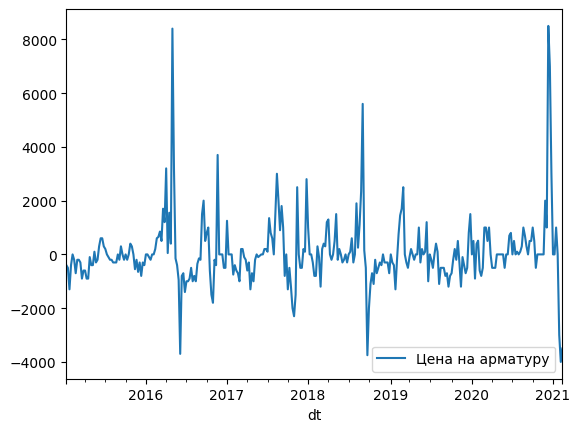

In [87]:
df_train_diff = train.diff().dropna()
df_train_diff.plot()

In [88]:
check_stationarity(df_train_diff['Цена на арматуру'])

ADF Statistic: -7.064366108463341
p-value: 5.125902269477374e-10
Критические значения:
1%: -3.451552879535732
5%: -2.8708786756338407
10%: -2.571745666091128


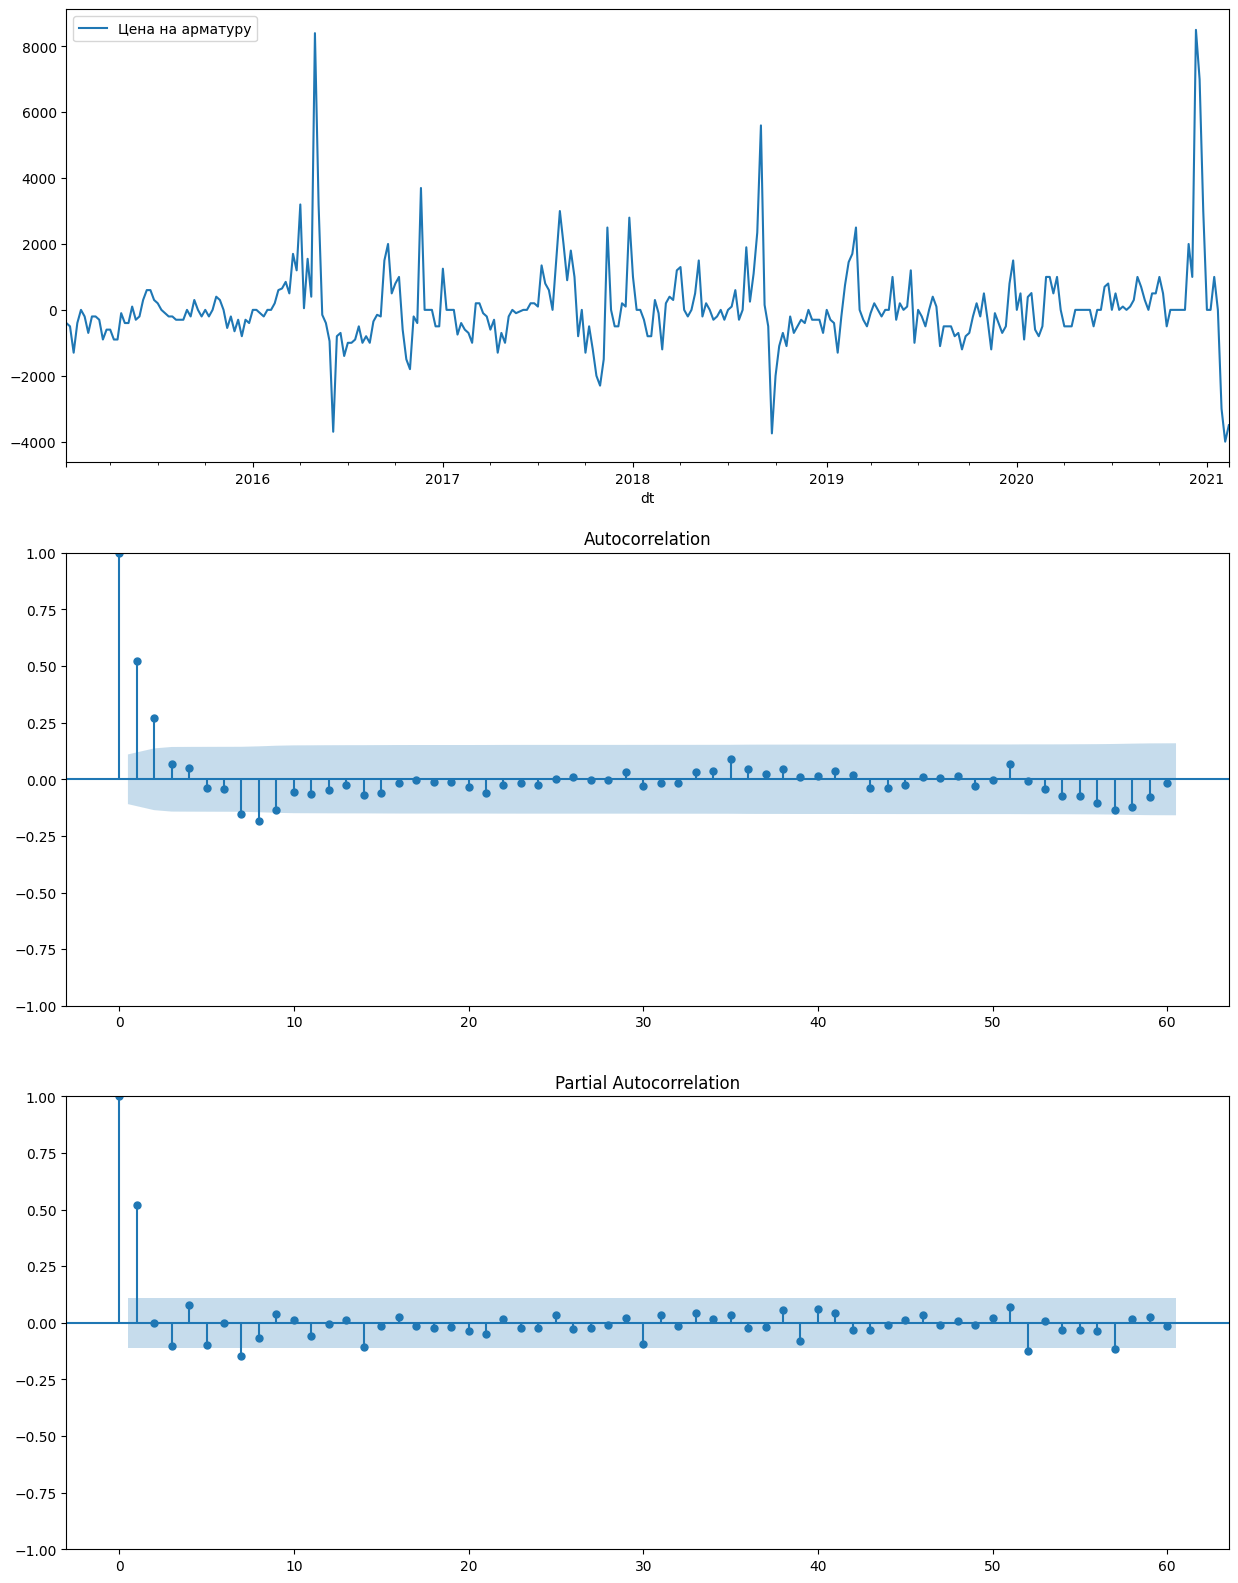

In [89]:
# вывод кореллограмм и ? (аргументировать зачем)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df_train_diff.plot(ax=ax[0])
plot_acf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[2]);

# Модели

## SARIMAX

In [90]:
# отключаем безвредные предупреждения
warnings.filterwarnings("ignore") 
  
# рассчёт лучших значений для ARIMA 
stepwise_fit = auto_arima(df_train_diff['Цена на арматуру'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5446.107, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5284.346, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5444.456, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5355.307, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5253.182, Time=2.06 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.42 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5333.499, Time=2.47 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=5254.972, Time=2.61 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=5255.023, Time=3.94 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=5274.421, Time=3.53 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=5251.788, Time=10.23 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  319
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood               -2617.527
Date:                             Mon, 24 Mar 2025   AIC                           5249.054
Time:                                     09:25:41   BIC                           5275.142
Sample:                                 01-12-2015   HQIC                          5259.486
                                      - 02-15-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4573      0.126     -3.624      0.000      -0.705      -0.210
ar.L2          0.2973      0.141      2.102      0.036       0.020       0.575
ma.L1          0.9701      0.130      7.491      0.000       0.716       1.224
ma.L2          0.2240      0.141      1.591      0.112      -0.052       0.500
ar.S.L12      -0.6864      0.052    -13.236      0.000      -0.788      -0.585
ar.S.L24      -0.3552      0.046     -7.732      0.000      -0.445      -0.265
sigma2      1.478e+06   6.23e+04     23.740      0.000    1.36e+06     1.6e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1823.67
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             1.82
Prob(H) (two-sided):                  0.17   Kurtosis:                        14.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
model = SARIMAX(train, 
				order = (3, 1, 2), 
				seasonal_order =(2, 1, 0, 12)) 

result = model.fit() 
result.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    Цена на арматуру   No. Observations:                  320
Model:             SARIMAX(3, 1, 2)x(2, 1, [], 12)   Log Likelihood               -2655.322
Date:                             Mon, 24 Mar 2025   AIC                           5326.644
Time:                                     09:25:52   BIC                           5356.459
Sample:                                 01-05-2015   HQIC                          5338.567
                                      - 02-15-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1854      5.000     -0.237      0.813     -10.985       8.614
ar.L2          0.0269      1.539      0.017      0.986      -2.990       3.044
ar.L3          0.2746      1.594      0.172      0.863      -2.849       3.398
ma.L1          1.5203      5.005      0.304      0.761      -8.289      11.329
ma.L2          0.5791      3.214      0.180      0.857      -5.719       6.877
ar.S.L12      -0.4321      0.038    -11.226      0.000      -0.508      -0.357
ar.S.L24      -0.2094      0.031     -6.718      0.000      -0.271      -0.148
sigma2      2.148e+06   1.13e+05     19.008      0.000    1.93e+06    2.37e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.63   Jarque-Bera (JB):               942.50
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
forecast = result.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

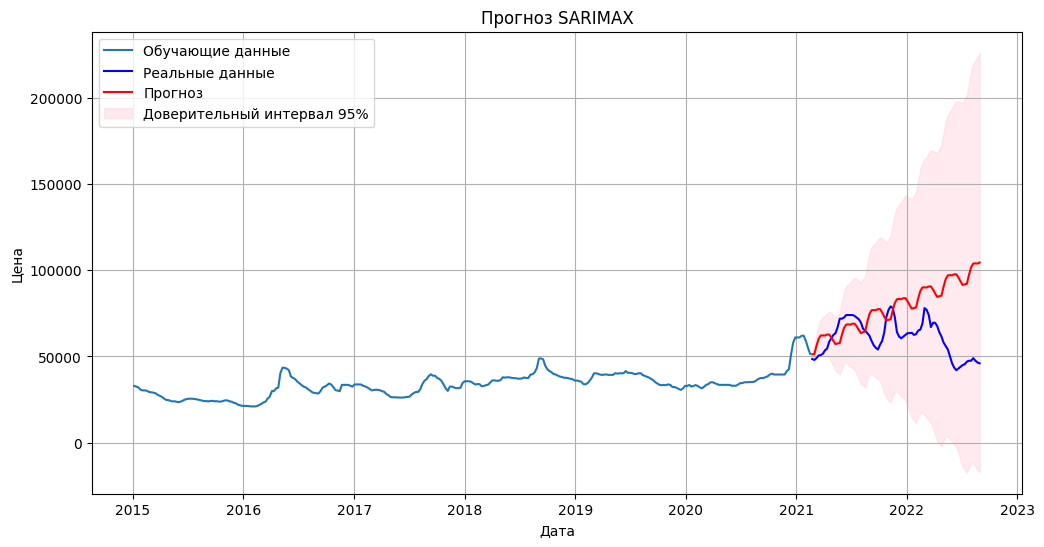

In [93]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающие данные')
plt.plot(test.index, test, label='Реальные данные', color='blue')
plt.plot(test.index, pred, label='Прогноз', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Доверительный интервал 95%')
plt.title('Прогноз SARIMAX')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

In [94]:
# Метрики
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
mape = mean_absolute_percentage_error(test, pred)
r2 = r2_score(test, pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 20509.22
MSE: 716554041.02
MAPE: 0.39%
R²: -5.8377
